In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [99]:

import numpy as np

# Load the data from the .npz file
data = np.load('/content/rotated_mnist (1).npz')

# Access the data arrays
rotated_x_train = data['x_train']
rotated_y_train = data['y_train']
rotated_x_test = data['x_test']
rotated_y_test = data['y_test']

# Print the shape of the data arrays to show the data clust
print("Shape of rotated_x_train:", rotated_x_train.shape)
print("Shape of rotated_y_train:", rotated_y_train.shape)
print("Shape of rotated_x_test:", rotated_x_test.shape)
print("Shape of rotated_y_test:", rotated_y_test.shape)


Shape of rotated_x_train: (152400, 28, 28)
Shape of rotated_y_train: (152400,)
Shape of rotated_x_test: (26004, 28, 28)
Shape of rotated_y_test: (26004,)


In [3]:
!pip install tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#Loading pre-trained vae model

In [4]:

latent_dim = 32  # Adjust as needed

def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        #z = self.sampling(z_mean, z_log_var)#added
        reconstruction = self.decoder(z)
        return reconstruction

    def sampling(self, z_mean, z_log_var):
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 14, 14, 32)     │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 7, 7, 64)       │         18,496 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 3136)           │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 16)             │         50,192 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 32)             │            544 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 32)             │            544 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z (Lambda)                │ (None, 32)             │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 70,096 (273.81 KB)

 Trainable params: 70,096 (273.81 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3136)                │         103,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 159,169 (621.75 KB)

 Trainable params: 159,169 (621.75 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
encoder = encoder #Use the original encoder definition.
decoder = decoder #Use the original decoder definition.
vae = VAE(encoder, decoder)

# Load weights:
encoder.load_weights("/content/drive/MyDrive/GSOC/GSOC/encoder_weights.weights.h5")
decoder.load_weights("/content/drive/MyDrive/GSOC/GSOC/decoder_weights.weights.h5")

print("VAE weights loaded, model reconstructed.")

VAE weights loaded, model reconstructed.


#Unsupervised ORACLE MODEL


In [47]:

_, _, z_train = encoder.predict(rotated_x_train)
_, _, z_test = encoder.predict(rotated_x_test)

latent_dim = z_train.shape[1]

class SymmetryGenerator(keras.Model):
    def __init__(self, latent_dim):
        super(SymmetryGenerator, self).__init__()
        self.net = keras.Sequential([
            layers.Dense(64, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(latent_dim, kernel_regularizer=keras.regularizers.l2(0.001))
        ])

    def call(self, inputs):
        return self.net(inputs)

def invariance_loss(z, generator, classifier, epsilon=1):#value of epsilon experimented
    z_prime = z + epsilon * generator(z)
    return tf.reduce_mean(tf.square(classifier(z) - classifier(z_prime)))

def normalization_loss(z, generator):
    norms = tf.norm(generator(z), axis=1)
    mean_norm = tf.reduce_mean(norms)
    return (
        tf.reduce_mean(tf.square(norms - 1.0)) +
        tf.reduce_mean(tf.square(norms - mean_norm))
    )

def orthogonality_loss(generators, z):
    loss = 0
    for i in range(len(generators)):
        for j in range(i+1, len(generators)):
            dot_prods = tf.reduce_sum(generators[i](z) * generators[j](z), axis=1)
            loss += tf.reduce_mean(tf.square(dot_prods))
    return loss

def build_classifier(latent_dim):
    classifier = keras.Sequential([
        layers.Input(shape=(latent_dim,)),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid') #Output layer is 1, as we are predicting the difference between z and z'
    ])
    classifier.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss='mse' #Using mean squared error as we are training to predict the difference between z and z'
    )
    return classifier


4763/4763 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
813/813 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [56]:
def train_symmetry_generator(z, num_generators=2):
    generators = [SymmetryGenerator(latent_dim) for _ in range(num_generators)]
    classifier = build_classifier(latent_dim)

    # Initialize optimizer after creating generators
    optimizer = keras.optimizers.Adam(learning_rate=1e-5) # Moved optimizer initialization here

    for epoch in range(100):
        with tf.GradientTape() as tape:
            inv_loss = sum(invariance_loss(z, gen, classifier) for gen in generators)
            norm_loss = sum(normalization_loss(z, gen) for gen in generators)
            ortho_loss = orthogonality_loss(generators, z) if num_generators > 1 else 0

            total_loss = inv_loss + norm_loss + ortho_loss

        # Get gradients for all generator variables
        all_gen_vars = [var for gen in generators for var in gen.trainable_variables]
        grads = tape.gradient(total_loss, all_gen_vars) # Calculate gradients for all generator variables

        # Apply gradients to all generator variables
        optimizer.apply_gradients(zip(grads, all_gen_vars)) # Apply gradients to all generator variables

        #Train classifier to predict the difference between z and z'
        z_prime = z + 1e-3 * generators[0](z)
        classifier.train_on_batch(z, z-z_prime)
        #print(f"Epoch: {epoch}, Total Loss: {total_loss}")

        #print(generators[0](z[:1]))
    return generators, classifier

In [57]:
generators, classifier = train_symmetry_generator(z_train, num_generators=2)

#Rotation Invariant Model

In [58]:
import matplotlib.pyplot as plt
def build_rotation_invariant_network(encoder, generators, latent_dim):

    input_image = keras.Input(shape=(28, 28, 1))

    # Encode the input image to latent space
    z_mean, z_log_var, z = encoder(input_image)

    # Apply the learned symmetry transformations
    transformed_z = z
    for generator in generators: #Apply each generator
        transformed_z = transformed_z + 0.1 * generator(transformed_z) #Apply the preserved symmetry.

    # Decode the transformed latent representation
    transformed_image = decoder(transformed_z)

    # Build the rotation-invariant model
    rotation_invariant_model = keras.Model(inputs=input_image, outputs=transformed_image)

    return rotation_invariant_model




In [62]:
rotation_invariant_network = build_rotation_invariant_network(encoder, generators, latent_dim)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


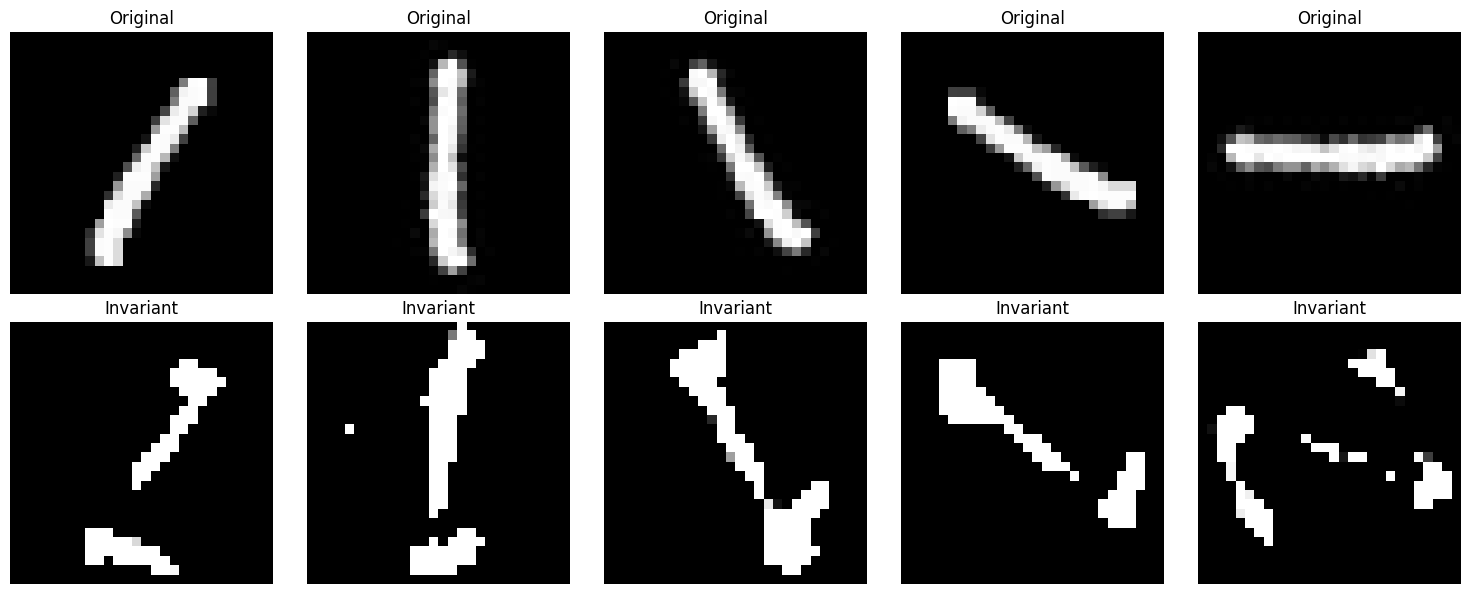

In [63]:
#Example Usage and Visualization:
def visualize_rotation_invariance(original_images, invariant_images, num_samples=5):
    plt.figure(figsize=(15, 6))
    for i in range(num_samples):
        plt.subplot(2, num_samples, i+1)
        plt.imshow(original_images[i].squeeze(), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        plt.subplot(2, num_samples, num_samples+i+1)
        plt.imshow(invariant_images[i].squeeze(), cmap='gray')
        plt.title("Invariant")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

#Generate invariant images
invariant_images = rotation_invariant_network.predict(rotated_x_train[:5])
visualize_rotation_invariance(rotated_x_train[:5], invariant_images)